In [1]:
from snn_delays.snn import SNN
from snn_delays.utils.dataset_loader import DatasetLoader
from snn_delays.experimental_models.snn_delay_prun import P_DelaySNN
from snn_delays.utils.train_utils import train, get_device, propagate_batch, to_plot
from snn_delays.utils.test_behavior import tb_addtask
from snn_delays.utils.visualization_utils import plot_taus
import numpy as np
device = get_device()

c:\Users\Alberto\anaconda3\envs\deepsnn\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Running on: cuda:0


In [2]:
time_window = 50
batch_size = 128 # 128: anil kag

ckpt_dir = 'addtask_03_2025_lr'

dataset = 'addtask_episodic'
#dataset = 'addtask' 

DL = DatasetLoader(dataset=dataset, caching='', num_workers=0, batch_size=batch_size, total_time=time_window)
train_loader, test_loader, dataset_dict = DL.get_dataloaders()
dataset_dict["time_ms"] = 150
#dataset_dict["time_ms"] = 50

In [3]:
structure = (48, 2)

# snn = P_DelaySNN(dataset_dict, structure=structure, connection_type='f', delay=(50,1), delay_type='h', delay_mask='random', n_pruned_delays=3,
#            reset_to_zero=False, win=time_window, loss_fn='mem_prediction', batch_size=batch_size, device=device, debug=True)

# snn.set_network()
# snn.use_amp = False
# snn.model_name = f'addask_d_ft' + '_mt'
# snn.input2spike_th = None
# snn.num_train_samples = batch_size

# snn_rnnd = P_DelaySNN(dataset_dict, structure=structure, connection_type='r', delay=(50,1), delay_type='h', delay_mask='random', n_pruned_delays=1,
#            reset_to_zero=False, win=time_window, loss_fn='mem_prediction', batch_size=batch_size, device=device, debug=True)

# snn_rnnd.set_network()
# snn_rnnd.use_amp = False
# snn_rnnd.model_name = f'addask_rnnd_ft' + '_mt'
# snn_rnnd.input2spike_th = None
# snn_rnnd.num_train_samples = batch_size

snn_mf = SNN(dataset_dict, structure=structure, connection_type='mf', delay=None, delay_type='',
           reset_to_zero=False, win=time_window, loss_fn='mem_prediction', batch_size=batch_size, device=device, debug=True)

snn_mf.multi_proj = 3

snn_mf.set_network()
snn_mf.use_amp = False
snn_mf.model_name = f'addask_mf_ft' + '_mt'
snn_mf.input2spike_th = None
snn_mf.num_train_samples = batch_size


snn_rnn = SNN(dataset_dict, structure=structure, connection_type='r', delay=None, delay_type='',
           reset_to_zero=False, win=time_window, loss_fn='mem_prediction', batch_size=batch_size, device=device, debug=True)

snn_rnn.set_network()
snn_rnn.use_amp = False
snn_rnn.model_name = f'addask_rnn_ft' + '_mt'
snn_rnn.input2spike_th = None
snn_rnn.num_train_samples = batch_size



[INFO] Delays: tensor([0])

[INFO] Delays i: tensor([0])

[INFO] Delays h: tensor([0])

[INFO] Delays o: tensor([0])
150
Delta t: 3.0 ms
mean of normal: 1.8211826606043786

[INFO] Delays: tensor([0])

[INFO] Delays i: tensor([0])

[INFO] Delays h: tensor([0])

[INFO] Delays o: tensor([0])
150
Delta t: 3.0 ms
mean of normal: 1.8211826606043786


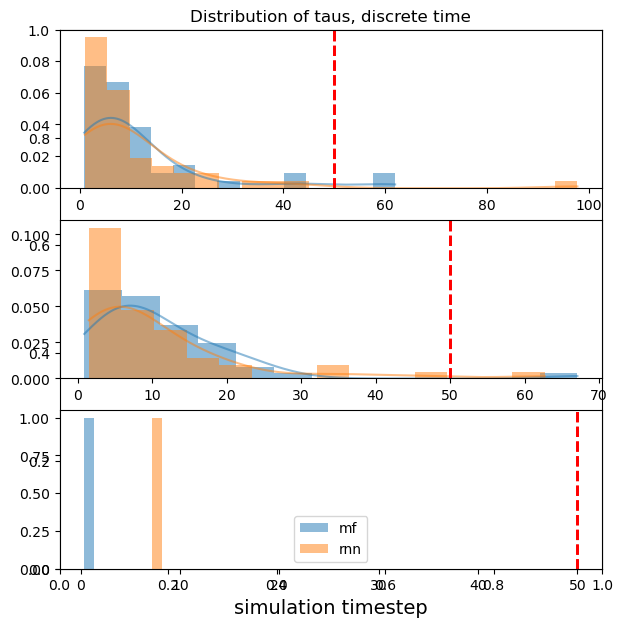

In [4]:
import matplotlib.pyplot as plt
plt.figure(figsize=(7,7))
plot_taus(snn_mf, label='mf')
plot_taus(snn_rnn, label='rnn')
plt.legend()

In [5]:
lr_tau = 0.01
train(snn_mf, train_loader, test_loader, 1e-3, 1000, ckpt_dir=ckpt_dir, test_behavior=tb_addtask, scheduler=(100, 0.95), clear=True, lr_tau=lr_tau)
train(snn_rnn, train_loader, test_loader, 1e-3, 1000, ckpt_dir=ckpt_dir, test_behavior=tb_addtask, scheduler=(100, 0.95), clear=True, lr_tau=lr_tau)

Model saved in  C:\Users\Alberto\OneDrive - UNIVERSIDAD DE SEVILLA\PythonData\Checkpoints\addtask_03_2025_lr
Mean Error: 0.0005033369525335729% 
--------------------------


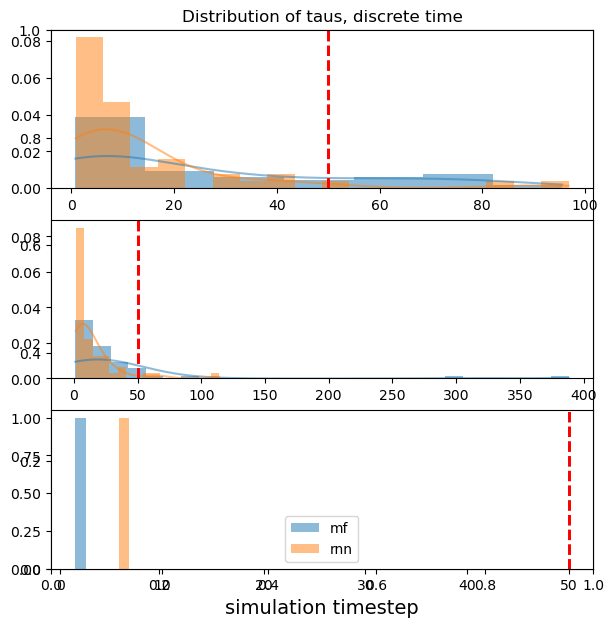

In [6]:
plt.figure(figsize=(7,7))
plot_taus(snn_mf, label='mf')
plot_taus(snn_rnn, label='rnn')
plt.legend()

Text(0.5, 1.0, 'train loss')

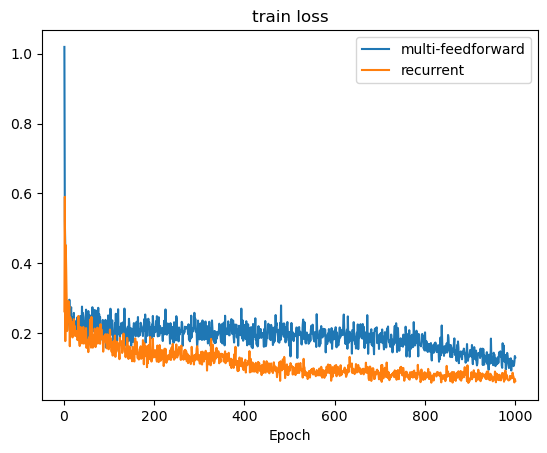

In [8]:
import numpy as np
from snn_delays.utils.visualization_utils import plot_per_epoch
loss_error = np.mean(np.array(snn_mf.train_loss)[:,1][-100:])
plot_per_epoch(snn_mf.train_loss, label = 'multi-feedforward')
plot_per_epoch(snn_rnn.train_loss, label = 'recurrent')
#plt.title(f'loss error = {loss_error}')

#plt.ylim(0, loss_error)
plt.title('train loss')

In [9]:
images, labels_mf = propagate_batch(snn_mf, test_loader)
_, labels_rnn = propagate_batch(snn_rnn, test_loader)

In [10]:
ref_mf = labels_mf[:,:int(0.1*time_window),0].T.cpu().numpy()
out_mf = snn_mf.mem_state['output'][int(0.9*time_window):].detach().cpu().numpy()

ref_rnn = labels_rnn[:,:int(0.1*time_window),0].T.cpu().numpy()
out_rnn = snn_rnn.mem_state['output'][int(0.9*time_window):].detach().cpu().numpy()


0.018025983
-0.006915275


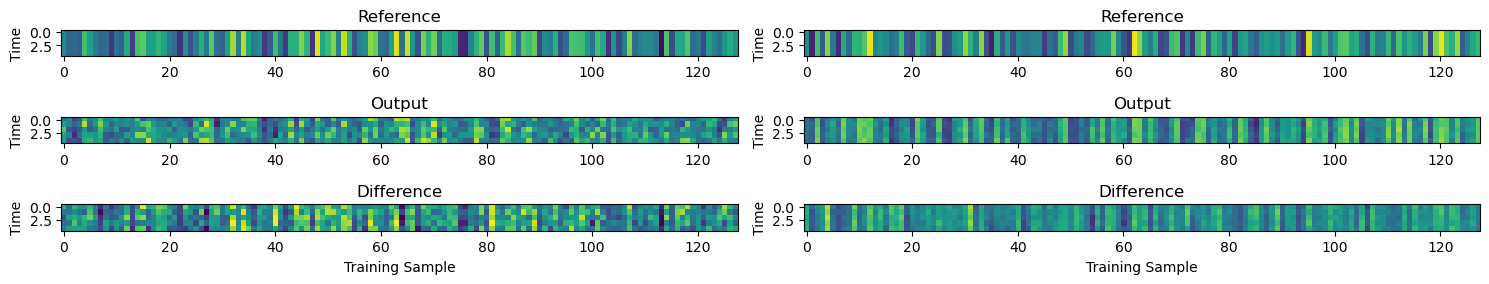

In [11]:
from snn_delays.utils.visualization_utils import plot_add_task, plot_add_task2, plot_add_task3, plot_add_task4
# Create a figure with 3 rows and N columns (for stacking results horizontally)
fig, axes = plt.subplots(3, 2, figsize=(15, 3))  # 3 rows, 2 columns

plot_add_task(out_mf, ref_mf, axes[:, 0])  
plot_add_task(out_rnn, ref_rnn, axes[:, 1])  

plt.tight_layout()
plt.show()

<Axes: xlabel='Index', ylabel='Value'>

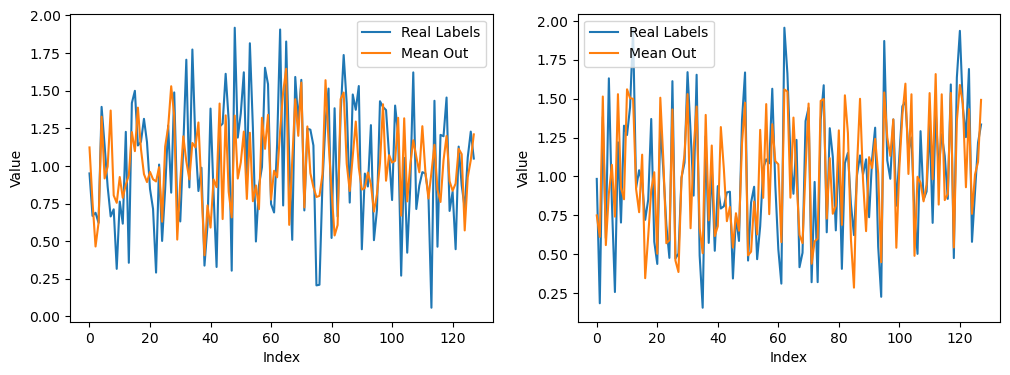

In [12]:
plt.figure(figsize=(12, 4))
plt.subplot(121)
plot_add_task2(out_mf, labels_mf)
plt.subplot(122)
plot_add_task2(out_rnn, labels_rnn)

<Axes: title={'center': 'output'}, xlabel='training sample', ylabel='time'>

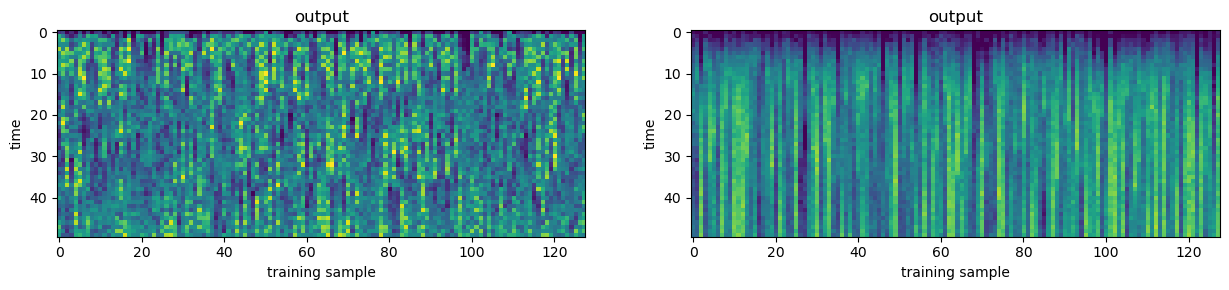

In [13]:
plt.figure(figsize=(15, 4))
plt.subplot(121)
plot_add_task3(snn_mf)
plt.subplot(122)
plot_add_task3(snn_rnn)

<Axes: title={'center': 'Dynamics of neuron = 0 of the layer output'}, xlabel='Time (ms)', ylabel='Membrane potential (mV)'>

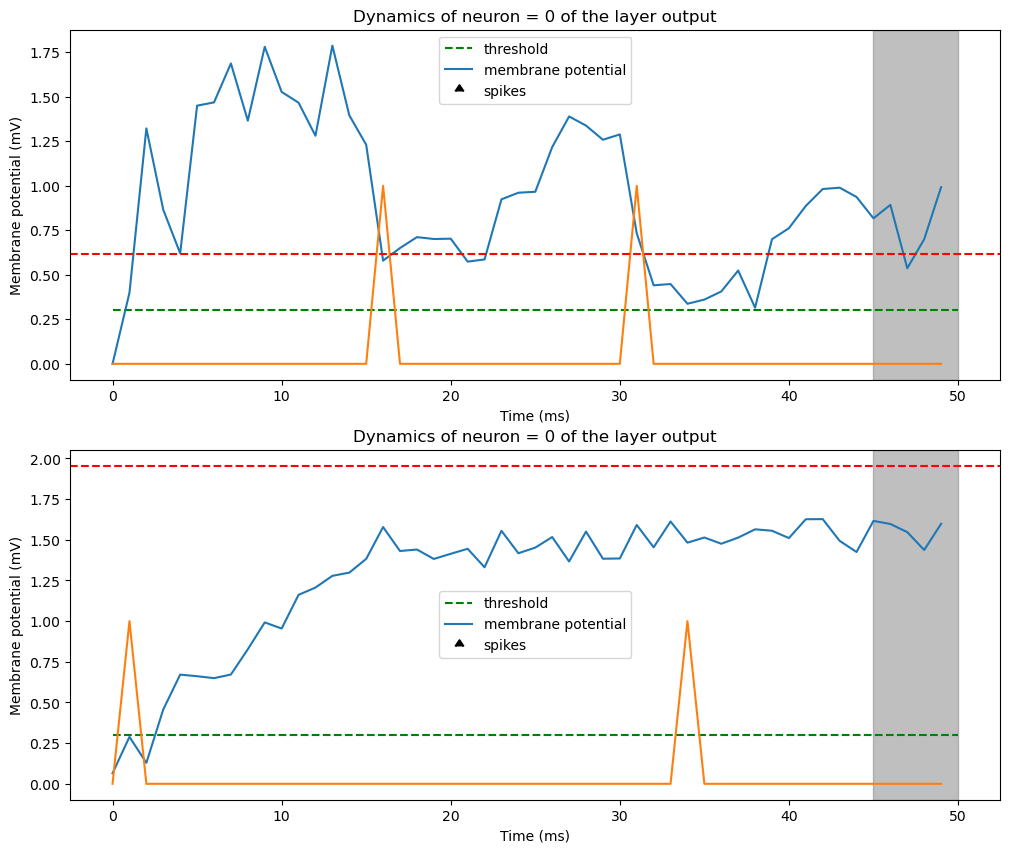

In [14]:
plt.figure(figsize=(12, 10))
plt.subplot(211)
plot_add_task4(snn_mf)
plt.subplot(212)
plot_add_task4(snn_rnn)
